# Software Project 2
Silviu - Andrei Matu, ICA, first year student, study formation 246/1

## Importing data

In [58]:
#importing libraries
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.stats import t
from sklearn.decomposition import PCA #only PCA is imported as a data analysis tool
from typing import List, Union

In [59]:
#these are the filenames
features_file_name='/Users/silviumatu/Desktop/Code/R/Software project 2/Demo_2/Imputation_1/extracted_features_time_1_imputed_data_1.csv'
RC_file_name='/Users/silviumatu/Desktop/Code/R/Software project 2/Demo_2/Imputation_1/RC_mild_imputed_data_1.csv'
pre_post_file_name='/Users/silviumatu/Desktop/Code/R/Software project 2/Demo_2/Imputation_1/pre_post_imputed_data_1.csv'

In [60]:
#reading data as pandas
data1 = pd.read_csv(features_file_name)
data2 = pd.read_csv(RC_file_name)
data3= pd.read_csv(pre_post_file_name)

#sorting the files by id to be sure all have the same order
data1 = data1.sort_values(by='id')
data2 = data2.sort_values(by='id')
data3 = data3.sort_values(by='id')

#copying ids in a another pd
subject_ids = data1["id"]
mdata1 = data1.iloc[:, 1:]
mdata2 = data2.iloc[:, 1:]
mdata3 = data3.iloc[:, 1:]

## Features selection

In [61]:
#here we specify which features to select; use the real feature name, such as 'x01';
#the full set of features (e.g., intercept, time_1, time_2, time_3) will be selected for all 'x...' feature 
selected_features=['x04']
selected_features

mdata1 = mdata1[[col for col in mdata1.columns if any(string in col for string in selected_features)]]

#we can select features from the other data set as well 
mdata2 = mdata2[[col for col in mdata2.columns if any(string in col for string in selected_features)]]
mdata3 = mdata3[[col for col in mdata3.columns if any(string in col for string in selected_features)]]

In [62]:
#we can also remove some features; uncomment the rows bellow to do so
#columns_to_remove=['intercept']
#mdata1 = mdata1[[col for col in mdata1.columns if all(string not in col for string in columns_to_remove)]]

#we can remove features from the other data set as well 
#mdata2 = mdata2[[col for col in mdata2.columns if all(string not in col for string in columns_to_remove)]]
#mdata3 = mdata3[[col for col in mdata3.columns if all(string not in col for string in columns_to_remove)]]

### Data preview

In [63]:
#previewing data
mdata1.head()

,intercept_x04,time_1_x04
0,1.392008,0.053195
1,-0.974571,-0.268293
2,0.385550,-0.719236
3,-0.916272,-0.203620
4,-0.474227,0.090243


In [64]:
mdata2.head()

,RC_x04
0,0
1,0
2,1
3,0
4,0


In [65]:
mdata3.head()

,x04_pre,x04_post
0,1.851587,1.364053
1,-0.245925,-0.858613
2,-0.712039,0.623165
3,-0.945096,-0.858613
4,-0.712039,-0.858613


In [66]:
subject_ids.head()

0    1
1    2
2    3
3    4
4    5
Name: id, dtype: int64

## Constructing the subjects class

In [67]:
#this is the class of "subject objects"
class Subject:
    def __init__(self, subject_id, xfeatures, rcfeatures, pre_post_features): #this is the constructor
        """
        Initialize a new Subject class object.
        :param subject_id: indicates the ID of the subject from the original dataset.
        :param xfeatures: An array of features used for clustering.
        :param rcfeatures: An array of features that are used to compare the k-mean clustering with external clinical judgment.
        :param pre_post_features: An array of features used to visualise clustering compared to .
        """
        self.id = subject_id 
        self.xfeatures = np.array(xfeatures)
        self.rcfeatures = np.array(rcfeatures)
        self.pre_post_features = np.array(pre_post_features)
        self.nxfeatures = len(xfeatures) #we are keeping the number of features as a class attribute
        self.nrcfeatures = len(rcfeatures)
        self.npre_post_features = len(pre_post_features)
        self.cluster_label = None # we are adding the cluster number as an attribute to the subject class objects

    def assign_to_cluster(self, cluster_id): #a public method to asign cluster mebership
        """
        Method to assing cluster appartenace.
        :param cluster_id: indicates the cluster no. where the subject has been attributed
        """
        self.cluster_label = cluster_id
        
    def __repr__(self): #a print method for visualising the subjects
        """
        Print info. for a Subject.
        """
        return f"Subject(ID={self.id}, "\
        f"XFeatures={self.xfeatures} (Number of features: {self.nxfeatures}), "\
        f"RCFeatures={self.rcfeatures} (Number of features: {self.nrcfeatures}), "\
        f"PPFeatures={self.pre_post_features} (Number of features: {self.npre_post_features})"

## Euclidian distance clustering

The Euclidean distance between a point $x$ and a centroid $c$, each having $n$ coordinates, is given by:

$$
D(x, c) = \sqrt{\sum_{i=1}^{n}(x_i - c_i)^2}
$$

Where:
- $x = (x_1, x_2, \ldots, x_n)$ is the vector of coordinates for the first point.
- $c = (c_1, c_2, \ldots, c_n)$ is the vector of coordinates for the centroid.
- $x_i$ and $c_i$ are the coordinates of $x$ and $c$ for the $i^{th}$ feature.

In [68]:
class KmeansClusterEuclidean:
    def __init__(self, subjects: List[Subject], k: int, max_iterations: int = 100): #a Cluster object is a list of Subject objects
        """
        Initialize a new ClusterEuclidian class object.
        :param subjects: the list of Subject class objects that will be clusterized.
        :param k: Number of clusters to be computed.
        :param max_iterations: Maximum number of iterations for the k-means algorithm.
        """
        self.subjects = subjects
        self.k = k
        self.max_iterations = max_iterations
        self.type="Euclidian" # we also have an identifier to indicate what kind of clustering algorithm we used
        self.centroids, self.clusters = self.k_mean_plus()

    def euclidean_distance(self, features_set_1, features_set_2):
        """
        Method for computing the Euclidean distance between the coordinates of two objects.
        :param features_set_1: features indicating the coordinates of the first object.
        :param features_set_2: features indicating the coordinates of the second object.
        :return: the computed Euclidean distance.
        """
        
        if len(features_set_1) != len(features_set_2):
            raise ValueError("The subject and the centroid have different number of features")
            
        squared_difference = [(x - c) ** 2 for x, c in zip(features_set_1, features_set_2)] #compute the squared difference on each feature
        distance = math.sqrt(sum(squared_difference)) #the distance is the sum of the squared differences
        return distance

    def k_mean_plus(self):
        """
        Perform k-means++ clustering.
        :return: A list of centroids and a list of cluster assignments for each subject.
        """
        # initialize centroids with k-means++
        centroids = [random.choice(self.subjects).xfeatures]

        for _ in range(1, self.k):
            distances = []
            for subject in self.subjects:
                subject_distances = []
                for centroid in centroids:
                    distance = self.euclidean_distance(subject.xfeatures, centroid)**2
                    subject_distances.append(distance)
                min_distance = min(subject_distances)
                distances.append(min_distance)

            total_distance = sum(distances)

            probabilities = []
            for distance in distances:
                probability = distance / total_distance
                probabilities.append(probability)

            cumulative_probabilities = []
            cumulative_sum = 0
            for probability in probabilities:
                cumulative_sum = cumulative_sum+probability
                cumulative_probabilities.append(cumulative_sum)

            r = random.random()
            next_centroid = None
            for i, subject in enumerate(self.subjects):
                if cumulative_probabilities[i] >= r:
                    next_centroid = subject.xfeatures
                    break

            if next_centroid is not None:
                centroids.append(next_centroid)

        #cluster assignment and centroid update
        for _ in range(self.max_iterations):
            # Cluster assignment
            clusters = [[] for _ in range(self.k)]
            for subject in self.subjects:
                distances = [self.euclidean_distance(subject.xfeatures, centroid) for centroid in centroids]
                closest_centroid = distances.index(min(distances))
                clusters[closest_centroid].append(subject)

            # centroids update
            new_centroids = []
            for cluster in clusters:
                new_centroid = np.mean([subject.xfeatures for subject in cluster], axis=0)
                new_centroids.append(new_centroid)

            # covenrgece check
            if np.array_equal(centroids, new_centroids):
                break
            centroids = new_centroids

        #final assgignement in the object atributes
        for cluster_index, cluster in enumerate(clusters):
                for subject in cluster:
                    subject.assign_to_cluster(cluster_index)

        return centroids, clusters

## Mahalanobis distance clustering

The Mahalanobis distance between a point $x$ and a centroid $c$ is given by:

$$
D(x, c) = \sqrt{(x - c)^T S^{-1} (x - c)}
$$

Where:
- $x = (x_1, x_2, \ldots, x_n)$ is the vector of coordinates for the point.
- $c = (c_1, c_2, \ldots, c_n)$ is the vector of coordinates for the centroid.
- $S^{-1}$ is the inverse of the covariance matrix $S$.
- $T$ denotes the transpose of a vector.

### Covariance matrix for the Mahalanobis distances

The ClusterMahalanobis class will have to include the computation of the covariance matrix for the xfeatures. The covariance between two variables \(X\) and \(Y\) is calculated using the formula:

$$
\text{Cov}(X, Y) = \frac{\sum_{i=1}^{n} (X_i - \overline{X}) \cdot (Y_i - \overline{Y})}{n - 1}
$$

where:
- $X_{i}$ and $Y_{i}$ are subject level values for any two $X$ and $Y$ variables.
- $\overline{X}$ and $\overline{Y}$ are the means for $X$ and $Y$.
- $n$ is the number of subjects.


In [69]:
class KmeansClusterMahalanobis:
    def __init__(self, subjects: List[Subject], k: int, max_iterations: int = 100): #this is the constructor
        """
        Initialize a new ClusterMahalanobis class object.
        :param subjects: the list of Subject class objects that will be clusterized.
        :param k: Number of clusters to be computed.
        :param max_iterations: Maximum number of iterations for the k-means algorithm.
        """
        self.subjects = subjects
        self.type="Mahalanobis"
        self.covariance_matrix= self._compute_covariance_matrix()
        self.inverse_covariance_matrix=self._compute_inverse_covariance_matrix()
        self.k = k
        self.max_iterations = max_iterations
        self.centroids, self.clusters = self.k_mean_plusM()
        
    def _compute_covariance_matrix(self):
        """
        Compute the covariance matrix for xfeatures of all subjects.
        """
        # initializing covariance matrix
        num_subjects = len(self.subjects)
        num_features = len(self.subjects[0].xfeatures)
        matrix = [[0 for _ in range(num_features)] for _ in range(num_features)] #the matrix has the dimension num_features x num_features

        # compute means for covaraince matrix
        feature_means = []
        for i in range(num_features):
            sum_features=0
            for subject in self.subjects:
                sum_features=sum_features + subject.xfeatures[i]
            mean_features=sum_features/num_subjects
            feature_means.append(mean_features)

        # compute covariance matrix
        for i in range(num_features):
            for j in range(num_features):
                sum_products = 0
                for subject in self.subjects:
                    diffrence_i = subject.xfeatures[i] - feature_means[i]
                    diffrence_j = subject.xfeatures[j] - feature_means[j]
                    sum_products = sum_products+ (diffrence_i * diffrence_j)
                covariance = sum_products / (num_subjects - 1)
                matrix[i][j] = covariance

        return matrix

    def _update_covariance_matrix(self):
        """
        A method to update the covariance matrix, if needed.
        """
        self.covariance_matrix = self.compute_covariance_matrix() #same as for the constructor


    def _compute_inverse_covariance_matrix(self):
        """
        Compute the inverse of the features covariance matrix.
        :return: the inverted covariance matrix or None if the matrix is singular.
        """
        try:
            return np.linalg.inv(self.covariance_matrix)
        except np.linalg.LinAlgError:
            print("Covariance matrix is singular and cannot be inverted.")
            return None
            

    def mahalanobis_distance(self, features_set_1, features_set_2):
        """
        Compute the Mahalanobis distance between the coordinates of two objects.
        :param features_set_1: features indicating the coordinates of the first object.
        :param features_set_2: features indicating the coordinates of the second object.
        :return: the computed Mahalanobis distance.
        """
        # check that the two set of features have the same length
        if len(features_set_1) != len(features_set_2):
            raise ValueError("The subject and the centroid have different number of features")
    
        diff = np.array(features_set_1) - np.array(features_set_2)
        distance = np.sqrt(np.dot(np.dot(diff.T, self.inverse_covariance_matrix), diff))

        return distance


    def k_mean_plusM(self):
        """
        Perform k-means++ clustering.
        :return: A list of centroids and a list of cluster assignments for each subject.
        """
        # initialize centroids, again with k-means++
        centroids = [random.choice(self.subjects).xfeatures]

        for _ in range(1, self.k):
            distances = []
            for subject in self.subjects:
                subject_distances = []
                for centroid in centroids:
                    distance = self.mahalanobis_distance(subject.xfeatures, centroid)**2
                    subject_distances.append(distance)
                min_distance = min(subject_distances)
                distances.append(min_distance)

            total_distance = sum(distances)

            probabilities = []
            for distance in distances:
                probability = distance / total_distance
                probabilities.append(probability)

            cumulative_probabilities = []
            cumulative_sum = 0
            for probability in probabilities:
                cumulative_sum = cumulative_sum+probability
                cumulative_probabilities.append(cumulative_sum)

            r = random.random()
            next_centroid = None
            for i, subject in enumerate(self.subjects):
                if cumulative_probabilities[i] >= r:
                    next_centroid = subject.xfeatures
                    break

            if next_centroid is not None:
                centroids.append(next_centroid)

        # assign clusters
        for _ in range(self.max_iterations):
            # Cluster assignment
            clusters = [[] for _ in range(self.k)]
            for subject in self.subjects:
                distances = [self.mahalanobis_distance(subject.xfeatures, centroid) for centroid in centroids]
                closest_centroid = distances.index(min(distances))
                clusters[closest_centroid].append(subject)

            # update centroids
            new_centroids = []
            for cluster in clusters:
                new_centroid = np.mean([subject.xfeatures for subject in cluster], axis=0)
                new_centroids.append(new_centroid)

            # convergence
            if np.array_equal(centroids, new_centroids):
                break
            centroids = new_centroids

        # final assignemnt
        for cluster_index, cluster in enumerate(clusters):
                for subject in cluster:
                    subject.assign_to_cluster(cluster_index)

        return centroids, clusters

## Intenal evaluation measures

In [70]:
class ClusterInternalEvaluation:

    #the constructor accepts as input both types of clustering results
    def __init__(self, cluster_results: Union[KmeansClusterEuclidean, KmeansClusterMahalanobis]):
        """
        Initialize a new class of object computing the results of internal evaluation measures.
        :param cluster_results: an object of type KmeansClusterEuclidiean ore KmeansClusterMahalanobis
        """
        self.cluster_results = cluster_results
        self.subjects = cluster_results.subjects
        self.type=cluster_results.type
        self.k = cluster_results.k
        self.max_iterations = cluster_results.max_iterations
        self.centroids = cluster_results.centroids
        self.clusters = cluster_results.clusters
        self.overall_silhouette_score, self.silhouette_scores = self._silhouette_score()
        self.dbi = self._davies_bouldin_index()

    
    def _silhouette_score(self):
        """
        Compute the Silhouette score for the given clusterization.
        :return: the overall Shilouette score and the invidiual subjects Shilouette scores.
        """
        silhouette_scores = []
    
        # calculate silhouette scores
        for i, cluster in enumerate(self.clusters):
            for subject in cluster:
                # mean distance to other points in the same cluster is in a
                if self.type == "Euclidian":
                    a = np.mean([self.cluster_results.euclidean_distance(subject.xfeatures, other_subject.xfeatures) for other_subject in cluster if other_subject != subject])
                elif self.type == "Mahalanobis":
                    a = np.mean([self.cluster_results.mahalanobis_distance(subject.xfeatures, other_subject.xfeatures) for other_subject in cluster if other_subject != subject])
    
                # mean distance to points in the nearest cluster is in b
                min_mean_distance = float('inf')
                for j, other_cluster in enumerate(self.clusters):
                    if j != i:  # Exclude the current cluster
                        if self.type == "Euclidian":
                            mean_distance = np.mean([self.cluster_results.euclidean_distance(subject.xfeatures, other_subject.xfeatures) for other_subject in other_cluster])
                        elif self.type == "Mahalanobis":
                            mean_distance = np.mean([self.cluster_results.mahalanobis_distance(subject.xfeatures, other_subject.xfeatures) for other_subject in other_cluster])
                        if mean_distance < min_mean_distance:
                            min_mean_distance = mean_distance
    
                b = min_mean_distance if min_mean_distance != float('inf') else 0
    
                # silhouette score for individual point
                if a < b:
                    silhouette_scores.append(1 - a/b)
                elif a == b:
                    silhouette_scores.append(0)
                else:
                    silhouette_scores.append(b/a - 1)
    
        # overall silhouette score
        overall_silhouette_score = np.mean(silhouette_scores) if silhouette_scores else 0
    
        return overall_silhouette_score, silhouette_scores
        

    def _davies_bouldin_index(self):
        """
        Compute the Davies Bouldin Index (DBI) score for the given clusterization.
        :return: the overall DBI.
        """
        
        dbi = 0

        # compute within cluster distances
        intra_cluster_distances = []
        for i, cluster in enumerate(self.clusters):
            if self.type == "Euclidian":
                s_i = np.mean([self.cluster_results.euclidean_distance(subject.xfeatures, self.centroids[i]) for subject in cluster])
            elif self.type == "Mahalanobis":
                s_i = np.mean([self.cluster_results.mahalanobis_distance(subject.xfeatures, self.centroids[i]) for subject in cluster])
            intra_cluster_distances.append(s_i)

        # compute between cluster distances
        for i, cluster_i in enumerate(self.clusters):
            max_similarity = 0
            for j, cluster_j in enumerate(self.clusters):
                if i != j:
                    if self.type == "Euclidian":
                        d_ij = self.cluster_results.euclidean_distance(self.centroids[i], self.centroids[j])
                    elif self.type == "Mahalanobis":
                        d_ij = self.cluster_results.mahalanobis_distance(self.centroids[i], self.centroids[j])
                    
                    R_ij = (intra_cluster_distances[i] + intra_cluster_distances[j]) / d_ij
                    if R_ij > max_similarity:
                        max_similarity = R_ij
            
            dbi = dbi+max_similarity

        # average across clusters
        dbi /= len(self.clusters)
        return dbi
        

    def _plot_silhouette(self):
        """
        Plot the Silhouette scores.
        """
        fig, ax1 = plt.subplots()
        fig.set_size_inches(18, 7)
    
        ax1.set_xlim([-1, 1])
        ax1.set_ylim(0, len(self.subjects) + (self.k + 1) * 10)
    
        y_lower = 10
        for i in range(self.k):
            cluster_i_scores = [self.silhouette_scores[j] for j in range(len(self.silhouette_scores)) if self.subjects[j].cluster_label == i]
            cluster_i_scores.sort()
    
            size_cluster_i = len(cluster_i_scores)
            y_upper = y_lower + size_cluster_i
    
            color = cm.nipy_spectral(float(i) / self.k)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_i_scores, facecolor=color, edgecolor=color, alpha=0.7)
    
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
    
        title = f"Silhouette plot for - {self.type} Clustering, {self.k} Clusters"
        ax1.set_title(title)
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=self.overall_silhouette_score, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
    
        plt.show()


## Elbow and kneedle methods for determining the number of clusters

In [71]:
def compute_elbow(subjects, max_k, max_iterations=100, use_mahalanobis=False):
    """
    Computes the elbow method using K-means clustering with Euclidean or Mahalanobis distance
    and then plots the elbow curve. Returns the WCSS values.

    :param subjects: List of Subject objects to cluster.
    :param max_k: Maximum number of clusters to test.
    :param max_iterations: Maximum number of iterations for the K-means algorithm.
    :param use_mahalanobis:if true use KmeansClusterMahalanobis, else use KmeansClusterEuclidean.
    :return: List of within-cluster sum of squares (WCSS) for each k.
    """
    wcss = []  # here we will store within cluster summ of squares

    for k in range(1, max_k + 1):
        if use_mahalanobis:
            clustering = KmeansClusterMahalanobis(subjects, k, max_iterations=max_iterations)
        else:
            clustering = KmeansClusterEuclidean(subjects, k, max_iterations=max_iterations)

        # calculate wcss
        if use_mahalanobis:
            # calculate wcss
            total_wcss = sum(
                clustering.mahalanobis_distance(subject.xfeatures, clustering.centroids[subject.cluster_label]) ** 2
                for subject in subjects)
            
        else:
            # same but with euclidian
            total_wcss = sum(
                np.sum((subject.xfeatures - clustering.centroids[subject.cluster_label]) ** 2)
                for subject in subjects)
        wcss.append(total_wcss)

    # plotting the elbow graph
    plt.plot(range(1, len(wcss) + 1), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    return wcss


In [72]:
def compute_kneedle(wcss):
    """
    Compute the location of the knee point in the WCSS (within-cluster sum of squares) curve
    and then plot the curve with the knee point.

    :param wcss: List of WCSS values for different numbers of clusters (k).
    :return: The index of the knee point, which corresponds to the optimal k.
    """
    # normalize wcss curve
    max_wcss = max(wcss)
    min_wcss = min(wcss)
    norm_wcss = (np.array(wcss) - min_wcss) / (max_wcss - min_wcss)
    
    # straight line from the first to the last wcss
    n_points = len(wcss)
    line = np.linspace(norm_wcss[0], norm_wcss[-1], n_points)
    
    # differences between wccs and the line
    diff_curve = norm_wcss - line
    
    # knee point will be were the difference is max
    knee_point = np.argmax(diff_curve)

    print("knee point is at cluster number:", knee_point + 1)
    return knee_point + 1


## Coross-validation

In [73]:
def assign_clusters(subjects, clustering_instance):
    """
    Assigns each subject to the nearest centroid using the distance function
    provided by the clustering_instance.

    :param subjects: List of Subject objects to be assigned to clusters.
    :param clustering_instance: An instance of KmeansClusterEuclidean or KmeansClusterMahalanobis with trained centroids.
    """
    for subject in subjects:
        # check what type of distance to compute
        if isinstance(clustering_instance, KmeansClusterEuclidean):
            distance_function = clustering_instance.euclidean_distance
        elif isinstance(clustering_instance, KmeansClusterMahalanobis):
            distance_function = clustering_instance.mahalanobis_distance
        else:
            raise ValueError("Pleace spcify clustering type.")

        # calculate the distance to centroids
        distances = [distance_function(subject.xfeatures, centroid) for centroid in clustering_instance.centroids]
        
        # index of the closest centroid
        nearest_centroid_index = np.argmin(distances)
        
        # assign subject to centroid
        subject.assign_to_cluster(nearest_centroid_index)


In [74]:
def holdout_cross_validation(subjects, k, n_splits=5, confidence=0.95):
    silhouette_scores_euclidean = []
    dbi_scores_euclidean = []
    silhouette_scores_mahalanobis = []
    dbi_scores_mahalanobis = []

    for _ in range(n_splits):
        # random splitting
        np.random.shuffle(subjects)
        split_point = int(len(subjects) * 0.7)  # 70% training, 30% validation
        training, validation = subjects[:split_point], subjects[split_point:]
        
        clustering_euclidean = KmeansClusterEuclidean(training, k)
        
        clustering_mahalanobis = KmeansClusterMahalanobis(training, k)

        # internal evaluation
        evaluation_euclidean_train = ClusterInternalEvaluation(clustering_euclidean)
        evaluation_mahalanobis_train = ClusterInternalEvaluation(clustering_mahalanobis)

        # assign new points
        assign_clusters(validation, clustering_euclidean)
        assign_clusters(validation, clustering_mahalanobis)

        # new evaluation
        evaluation_euclidean_val = ClusterInternalEvaluation(clustering_euclidean)
        evaluation_mahalanobis_val = ClusterInternalEvaluation(clustering_mahalanobis)

        # save result for validation
        silhouette_scores_euclidean.append(evaluation_euclidean_val.overall_silhouette_score)
        dbi_scores_euclidean.append(evaluation_euclidean_val.dbi)
        silhouette_scores_mahalanobis.append(evaluation_mahalanobis_val.overall_silhouette_score)
        dbi_scores_mahalanobis.append(evaluation_mahalanobis_val.dbi)

    # comupte averages
    results = {}
    for name, scores in [('euclidean_silhouette', silhouette_scores_euclidean), 
                         ('euclidean_dbi', dbi_scores_euclidean),
                         ('mahalanobis_silhouette', silhouette_scores_mahalanobis),
                         ('mahalanobis_dbi', dbi_scores_mahalanobis)]:
        
        mean_score = np.mean(scores)
        std_err = np.std(scores) / np.sqrt(n_splits)
        h = std_err * t.ppf((1 + confidence) / 2, n_splits - 1)
        
        results[name] = {
            'mean': mean_score,
            'conf_int': (mean_score - h, mean_score + h)
        }

    return results

## External evaluation

In [75]:
class ThreeClusterExternalEvaluation:
    def __init__(self, kmeans_cluster: Union[KmeansClusterEuclidean, KmeansClusterMahalanobis], f):
        """
        Initialize the ThreeClusterExternalEvaluation class.
        :param kmeans_cluster: An instance of KmeansCluster (Euclidean or Mahalanobis).
        :param f: The feature index based on which the cluster labels will be modified.
        """
        # !!!check if the number of clusters in kmeans_cluster is 3
        if len(kmeans_cluster.centroids) != 3:
            raise ValueError("the number of clusters must be 3!!!!")

        self.kmeans_cluster = kmeans_cluster
        self.refference_attirbuite = f-1
        self.subjects = kmeans_cluster.subjects

        # recode rcfeatures
        self.rcfeature_neg1, self.rcfeature_0, self.rcfeature_1 = self._modify_rcfeatures()
        
        self.metrics_smallest = {}
        self.metrics_largest = {}
        self.metrics_other = {}
        self.average_metrics = {}

    def _modify_rcfeatures(self):
        """
        Create binary versions of rcfeatures for -1, 0, and 1 values.
        :return: Three lists of binary features corresponding to rcfeature values -1, 0, and 1.
        """
        rcfeature_neg1 = []
        rcfeature_0 = []
        rcfeature_1 = []

        for subject in self.subjects:
            rcfeature_neg1.append(1 if subject.rcfeatures == -1 else 0)
            rcfeature_0.append(1 if subject.rcfeatures == 0 else 0)
            rcfeature_1.append(1 if subject.rcfeatures == 1 else 0)

        return rcfeature_neg1, rcfeature_0, rcfeature_1

    def generate_modified_cluster_labels(self):
        """
        Generate three modified versions of the subject.cluster_label based on the reference attribute.
        """
        centroids = self.kmeans_cluster.centroids
        f = self.refference_attirbuite

        feature_values = []
        for centroid in centroids:
            reference_feature_value = centroid[f]
            feature_values.append(reference_feature_value)


        # find the min and max values among the centroids for feature f
        min_value = min(feature_values)
        max_value = max(feature_values)

        # initialize the modified labels
        modified_label_smallest = []
        modified_label_largest = []
        modified_label_other = []

        for subject in self.subjects:
            cluster_index = subject.cluster_label

            # Check if the feature f of this cluster's centroid is the smallest or largest
            if centroids[cluster_index][f] == min_value:
                modified_label_smallest.append(1)
                modified_label_largest.append(0)
                modified_label_other.append(0)
            elif centroids[cluster_index][f] == max_value:
                modified_label_smallest.append(0)
                modified_label_largest.append(1)
                modified_label_other.append(0)
            else:
                modified_label_smallest.append(0)
                modified_label_largest.append(0)
                modified_label_other.append(1)

        return modified_label_smallest, modified_label_largest, modified_label_other


    def compute_metrics(self, predicted_labels, ground_truth):
        tp = 0 
        fp = 0
        fn = 0
        tn = 0
    
        auc = 0
        auprc = 0
        prev_fpr = 0
        prev_recall = 0
        prev_precision = 1
    
        # Special function
        sorted_labels = sorted(zip(predicted_labels, ground_truth), key=lambda x: x[0], reverse=True)
    
        # Confusion matrix
        for i in range(len(predicted_labels)):
            if ground_truth[i] == 1:
                if predicted_labels[i] == 1:
                    tp += 1
                else:
                    fn += 1
            else:
                if predicted_labels[i] == 1:
                    fp += 1
                else:
                    tn += 1
    
            # Calculate AUC and AUPRC
            if i < len(sorted_labels) - 1:
                fpr = fp / (fp + tn) if fp + tn > 0 else 0
                tpr = tp / (tp + fn) if tp + fn > 0 else 0
    
                auc += (fpr - prev_fpr) * tpr
                prev_fpr = fpr
    
                precision = tp / (tp + fp) if tp + fp > 0 else 0
                recall = tpr
                auprc += (recall - prev_recall) * prev_precision
                prev_recall = recall
                prev_precision = precision
    
        # Calculate overall metrics
        accuracy = (tp + tn) / len(ground_truth) if len(ground_truth) > 0 else 0
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
        # Apply constraints to AUC, AUPRC, recall, and F1-score
        auc = max(auc, 0)
        auprc = max(auprc, 0)
        recall = max(recall, 0)
        f1_score = max(f1_score, 0)
    
        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "auc": auc,
            "auprc": auprc
        }
    
    def evaluate_cluster_labels(self):
        """
        Evaluate the modified cluster labels against the ground truth labels in the modified rcfeatures.
        """
        mod_label_smallest, mod_label_largest, mod_label_other = self.generate_modified_cluster_labels()

        self.metrics_smallest = self.compute_metrics(mod_label_smallest, self.rcfeature_neg1)
        self.metrics_largest = self.compute_metrics(mod_label_largest, self.rcfeature_0)
        self.metrics_other = self.compute_metrics(mod_label_other, self.rcfeature_1)

    def plot_metrics(self, metrics):
        """
        Plot AUROC and AUPRC for given metrics.
        :param metrics: Dictionary containing 'auc' and 'auprc' values.
        """
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # AUROC
        ax[0].plot([0, 1], [0, 1], 'k--')
        ax[0].plot([0, metrics['auc']], [1, metrics['auc']], 'r', label='AUROC')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('Receiver Operating Characteristic')
        ax[0].legend(loc='best')

        # AUPRC
        ax[1].plot([0, metrics['auprc']], [1, metrics['auprc']], 'b', label='AUPRC')
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        ax[1].set_title('Precision-Recall Curve')
        ax[1].legend(loc='best')

        plt.show()

    def compute_average_metrics(self):
        """
        Compute the average of each metric across all label sets and store them.
        """
        self.average_metrics = {}
        num_label_sets = 3  # Since you have three label sets

        for metric in self.metrics_smallest.keys():
            self.average_metrics[metric] = 0

        for metrics in [self.metrics_smallest, self.metrics_largest, self.metrics_other]:
            for metric, value in metrics.items():
                self.average_metrics[metric] += value

        for metric in self.average_metrics.keys():
            self.average_metrics[metric] /= num_label_sets

    def print_metrics(self):
        """
        Print the computed metrics for each label set and the average metrics.
        """
        for label_set, metrics in [("Smallest", self.metrics_smallest), 
                                   ("Largest", self.metrics_largest), 
                                   ("Other", self.metrics_other)]:
            print(f"Metrics for {label_set} Label:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value:.4f}")
            print("\n")

        print("Average Metrics Across Label Sets:")
        for metric, value in self.average_metrics.items():
            print(f"  {metric}: {value:.4f}")

    
    def plot_all_metrics(self):
        """
        Plot AUROC and AUPRC for all metrics sets.
        """
        for label_set, metrics in [("Smallest", self.metrics_smallest), 
                                   ("Largest", self.metrics_largest), 
                                   ("Other", self.metrics_other)]:
            print(f"Plotting for {label_set} Label:")
            self.plot_metrics(metrics)

In [76]:
def three_external_holdout_cross_validation(subjects, feature_index, n_splits=5, confidence=0.95):
    k = 3
    all_metrics = []

    for _ in range(n_splits):
        np.random.shuffle(subjects)
        split_point = int(len(subjects) * 0.7)
        training, validation = subjects[:split_point], subjects[split_point:]

        clustering_euclidean = KmeansClusterEuclidean(training, k)
        clustering_mahalanobis = KmeansClusterMahalanobis(training, k)

        external_eval_euclidean = ThreeClusterExternalEvaluation(clustering_euclidean, feature_index)
        external_eval_euclidean.evaluate_cluster_labels()
        external_eval_euclidean.compute_average_metrics()

        external_eval_mahalanobis = ThreeClusterExternalEvaluation(clustering_mahalanobis, feature_index)
        external_eval_mahalanobis.evaluate_cluster_labels()
        external_eval_mahalanobis.compute_average_metrics()

        all_metrics.append([
            external_eval_euclidean.metrics_smallest, 
            external_eval_euclidean.metrics_largest, 
            external_eval_euclidean.metrics_other,
            external_eval_euclidean.average_metrics,
            external_eval_mahalanobis.metrics_smallest, 
            external_eval_mahalanobis.metrics_largest, 
            external_eval_mahalanobis.metrics_other,
            external_eval_mahalanobis.average_metrics])

    results_euclidean = {}
    results_mahalanobis = {}

    for metric_name in all_metrics[0][0].keys():
        euclidean_metrics = [metric[metric_name] for split in all_metrics for metric in split[:4]]
        mahalanobis_metrics = [metric[metric_name] for split in all_metrics for metric in split[4:]]

        mean_euclidean = np.mean(euclidean_metrics)
        sd_euclidean = np.std(euclidean_metrics)
        ci_euclidean = t.ppf((1 + confidence) / 2, len(euclidean_metrics) - 1) * sd_euclidean / np.sqrt(len(euclidean_metrics))
        results_euclidean[metric_name] = {'mean': mean_euclidean, 'sd': sd_euclidean, '95% CI': (mean_euclidean - ci_euclidean, mean_euclidean + ci_euclidean)}

        mean_mahalanobis = np.mean(mahalanobis_metrics)
        sd_mahalanobis = np.std(mahalanobis_metrics)
        ci_mahalanobis = t.ppf((1 + confidence) / 2, len(mahalanobis_metrics) - 1) * sd_mahalanobis / np.sqrt(len(mahalanobis_metrics))
        results_mahalanobis[metric_name] = {'mean': mean_mahalanobis, 'sd': sd_mahalanobis, '95% CI': (mean_mahalanobis - ci_mahalanobis, mean_mahalanobis + ci_mahalanobis)}

    return results_euclidean, results_mahalanobis

### Some plotting functions

In [77]:
def plot_subject_pre_post(subject):
    pre_post_data = subject.pre_post_features
    cluster_label = subject.cluster_label
    
    x = np.arange(len(pre_post_data))
    plt.plot(x, pre_post_data, label=f'Cluster {cluster_label}')

In [78]:
def plot_clusters(subjects, centroids):
    colors = ['b', 'g', 'r']
    clusters = {}
    all_features = []
    for subject in subjects:
        if subject.cluster_label not in clusters:
            clusters[subject.cluster_label] = []
        clusters[subject.cluster_label].append(subject.pre_post_features)
        all_features.append(subject.pre_post_features)

    all_features = np.array(all_features)

    for label, features in clusters.items():
        color = colors[label]
        features = np.array(features)
        plt.scatter(features[:, 0], features[:, 1], color=color, label=f"Cluster {label}")
        centroid = centroids[label]
        plt.scatter(centroid[0], centroid[1], marker='x', s=100, color=color, label=f"Centroid {label}")

    plt.xlabel("Pre-Post Feature 1")
    plt.ylabel("Pre-Post Feature 2")
    plt.title("2D Plot of Clusters with Pre-Post Features")

    plt.xlim([np.min(all_features[:, 0]) - 1, np.max(all_features[:, 0]) + 1])
    plt.ylim([np.min(all_features[:, 1]) - 1, np.max(all_features[:, 1]) + 1])

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

## Results

### Demo of the classes and functions

In [79]:
#constructing the Subject objects as a list of Subjects
subjectsList = [Subject(sid, row1, row2, row3) for sid, row1, row2, row3 in zip(subject_ids, mdata1.values, mdata2.values, mdata3.values)]

In [80]:
#priting a few Subjects just to demo their construction
for subject in subjectsList[:3]:
    print(subject)

Subject(ID=1, XFeatures=[1.39200773 0.05319466] (Number of features: 2), RCFeatures=[0] (Number of features: 1), PPFeatures=[1.85158663 1.36405315] (Number of features: 2)
Subject(ID=2, XFeatures=[-0.97457109 -0.26829267] (Number of features: 2), RCFeatures=[0] (Number of features: 1), PPFeatures=[-0.24592502 -0.85861259] (Number of features: 2)
Subject(ID=3, XFeatures=[ 0.38555022 -0.71923588] (Number of features: 2), RCFeatures=[1] (Number of features: 1), PPFeatures=[-0.71203872  0.62316457] (Number of features: 2)


In [81]:
cluster_euclidean = KmeansClusterEuclidean(subjectsList, k=4, max_iterations=100)

In [82]:
for i, cluster in enumerate(cluster_euclidean.clusters):
    print(f"Cluster {i}:")
    for subject in cluster[:2]:
        print(f"   Subject ID: {subject.id}, Features: {subject.xfeatures}")

Cluster 0:
   Subject ID: 1, Features: [1.39200773 0.05319466]
   Subject ID: 3, Features: [ 0.38555022 -0.71923588]
Cluster 1:
   Subject ID: 2, Features: [-0.97457109 -0.26829267]
   Subject ID: 4, Features: [-0.91627198 -0.20362023]
Cluster 2:
   Subject ID: 15, Features: [-0.4971761   0.72033413]
   Subject ID: 16, Features: [-0.91224564  0.98901618]
Cluster 3:
   Subject ID: 18, Features: [ 2.11969559 -2.26403571]
   Subject ID: 33, Features: [ 1.54298556 -2.07812653]


In [83]:
for i, centroid in enumerate(cluster_euclidean.centroids):
    print(f"Centroid {i}, Features: {centroid}")

Centroid 0, Features: [ 0.73496207 -0.15108005]
Centroid 1, Features: [-0.72870946 -0.05237258]
Centroid 2, Features: [-0.36802882  1.4508356 ]
Centroid 3, Features: [ 1.66422525 -1.54794989]


In [84]:
cluster_mahalanobis = KmeansClusterMahalanobis(subjectsList, k=4, max_iterations=100)

In [85]:
for i, centroid in enumerate(cluster_mahalanobis.centroids):
    print(f"Centroid {i}, Features: {centroid}")

Centroid 0, Features: [-0.69090307 -0.1097042 ]
Centroid 1, Features: [-0.26667386  1.21889941]
Centroid 2, Features: [ 1.08603101 -1.36162589]
Centroid 3, Features: [1.47887791 0.25799295]


In [86]:
for i, cluster in enumerate(cluster_mahalanobis.clusters):
    print(f"Cluster {i}:")
    for subject in cluster[:2]:
        print(f"   Subject ID: {subject.id}, Features: {subject.xfeatures}")

Cluster 0:
   Subject ID: 2, Features: [-0.97457109 -0.26829267]
   Subject ID: 4, Features: [-0.91627198 -0.20362023]
Cluster 1:
   Subject ID: 15, Features: [-0.4971761   0.72033413]
   Subject ID: 16, Features: [-0.91224564  0.98901618]
Cluster 2:
   Subject ID: 3, Features: [ 0.38555022 -0.71923588]
   Subject ID: 18, Features: [ 2.11969559 -2.26403571]
Cluster 3:
   Subject ID: 1, Features: [1.39200773 0.05319466]
   Subject ID: 29, Features: [1.0914989  0.28338752]


### Internal evaluation

In [87]:
evaluation_euclidian = ClusterInternalEvaluation(cluster_euclidean)
print("Davies-Bouldin Index:", evaluation_euclidian.dbi)
print("Overall Silhouette Score:", evaluation_euclidian.overall_silhouette_score)

Davies-Bouldin Index: 0.8897633391828743
Overall Silhouette Score: 0.4154457733126217


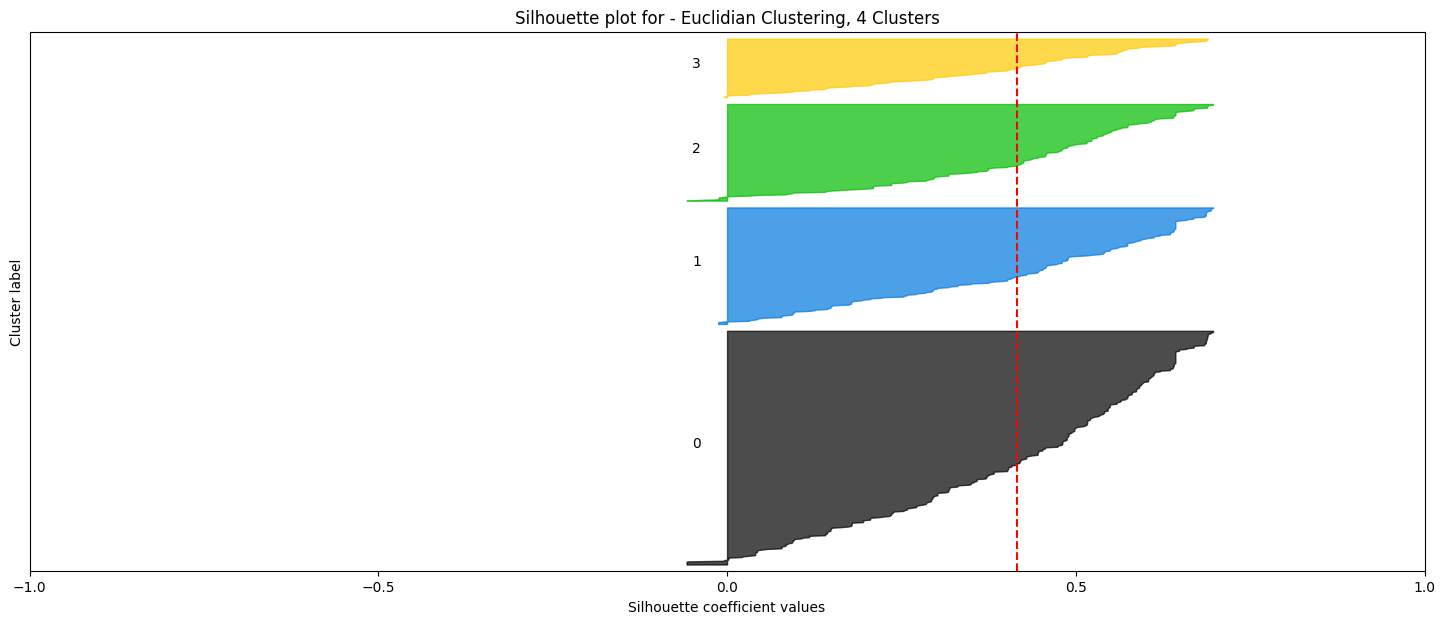

In [88]:
evaluation_euclidian._plot_silhouette()

Davies-Bouldin Index: 0.8800545284643146
Overall Silhouette Score: 0.4338636056478455


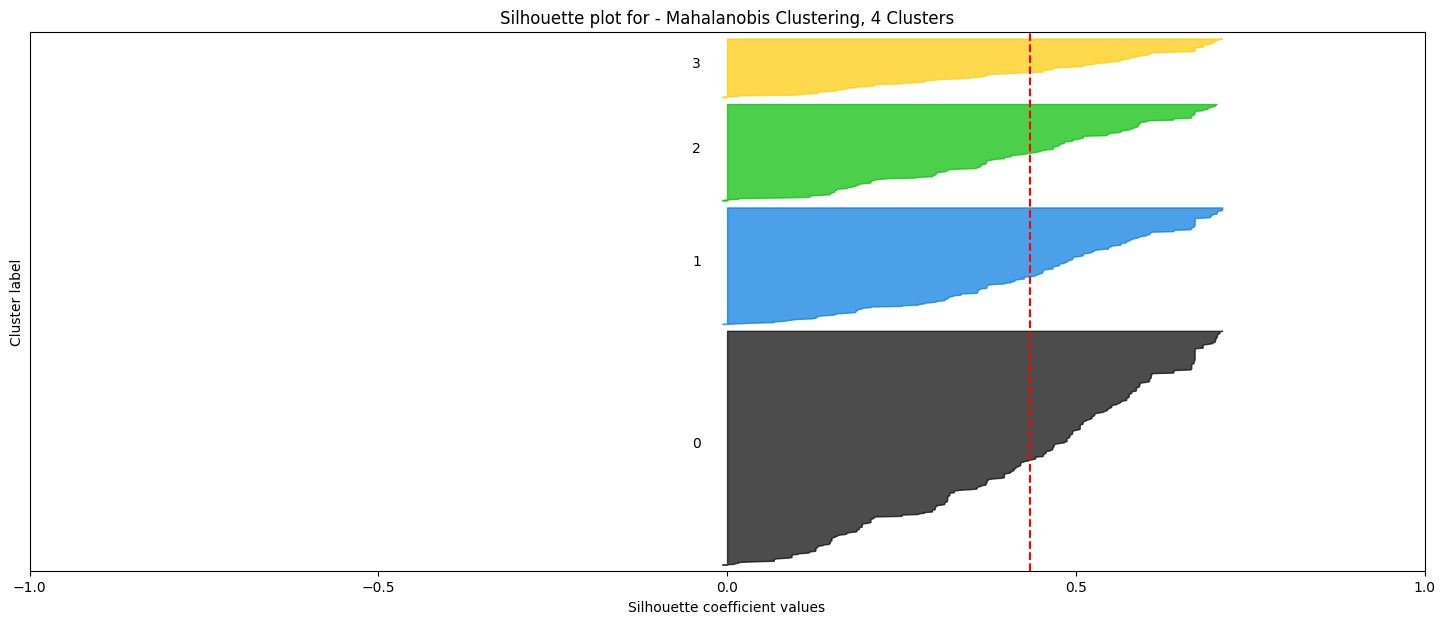

In [89]:
evaluation_mahalanobis = ClusterInternalEvaluation(cluster_mahalanobis)
print("Davies-Bouldin Index:", evaluation_mahalanobis.dbi)
print("Overall Silhouette Score:", evaluation_mahalanobis.overall_silhouette_score)
evaluation_mahalanobis._plot_silhouette()

In [90]:
cluster_mahalanobis3 = KmeansClusterMahalanobis(subjectsList, k=3, max_iterations=100)

Davies-Bouldin Index: 0.8515150713345437
Overall Silhouette Score: 0.4082494995139261


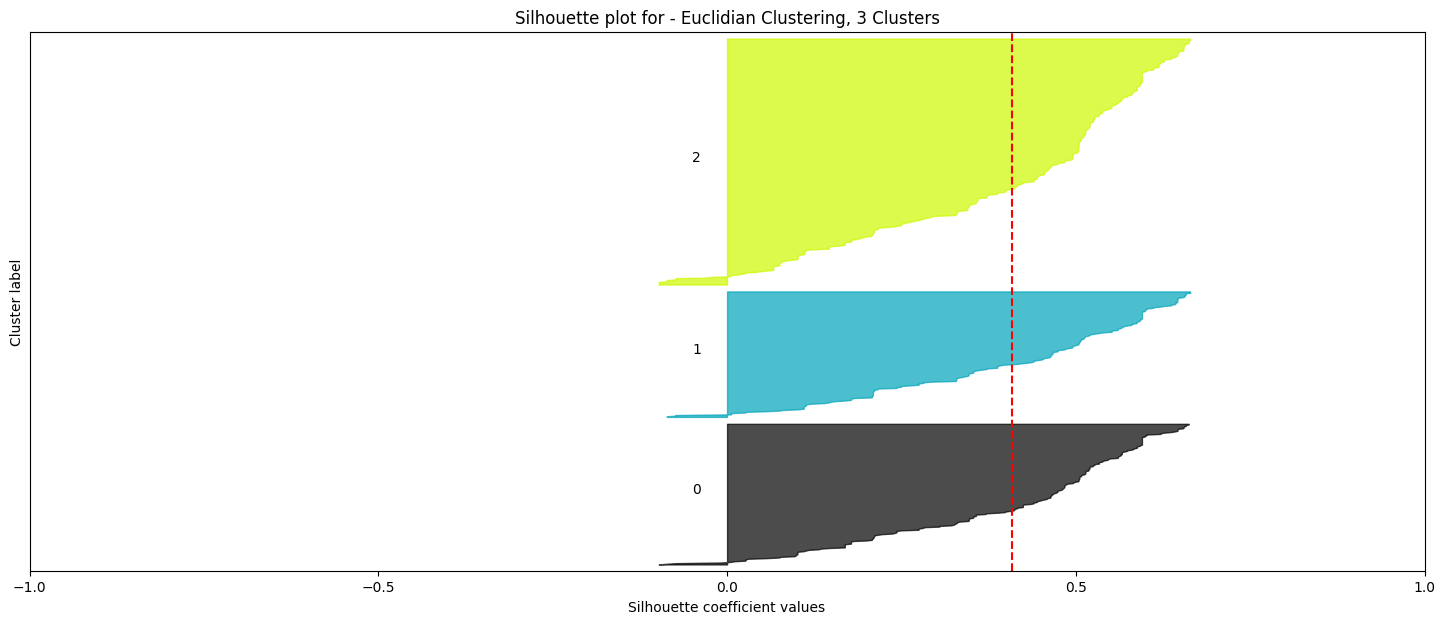

In [121]:
evaluation_euclidian3 = ClusterInternalEvaluation(cluster_euclidean3)
print("Davies-Bouldin Index:", evaluation_euclidian3.dbi)
print("Overall Silhouette Score:", evaluation_euclidian3.overall_silhouette_score)
evaluation_euclidian3._plot_silhouette()

In [92]:
cluster_mahalanobis = KmeansClusterMahalanobis(subjectsList, k=2, max_iterations=100)

Davies-Bouldin Index: 0.8897633391828743
Overall Silhouette Score: 0.4154457733126217


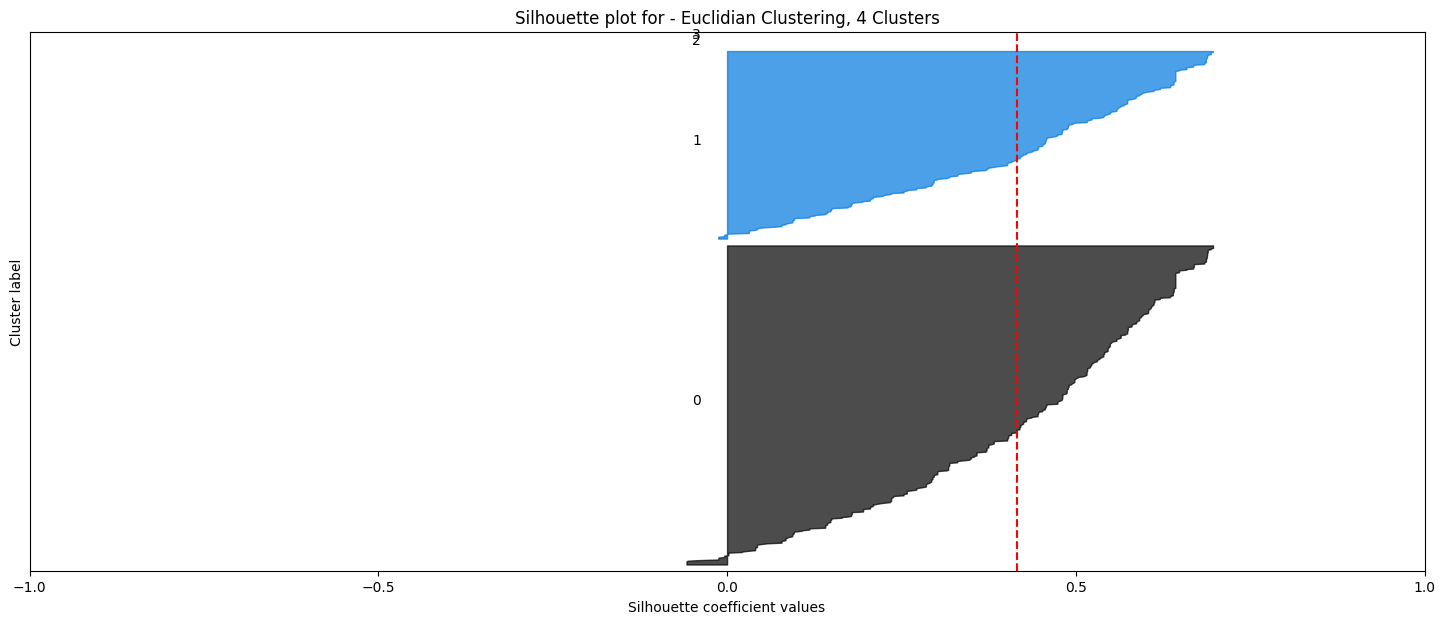

In [93]:
evaluation_euclidian = ClusterInternalEvaluation(cluster_euclidean)
print("Davies-Bouldin Index:", evaluation_euclidian.dbi)
print("Overall Silhouette Score:", evaluation_euclidian.overall_silhouette_score)
evaluation_euclidian._plot_silhouette()

In [118]:
cluster_mahalanobis3 = KmeansClusterMahalanobis(subjectsList, k=3, max_iterations=100)

Davies-Bouldin Index: 0.8538647064004228
Overall Silhouette Score: 0.4249074480621474


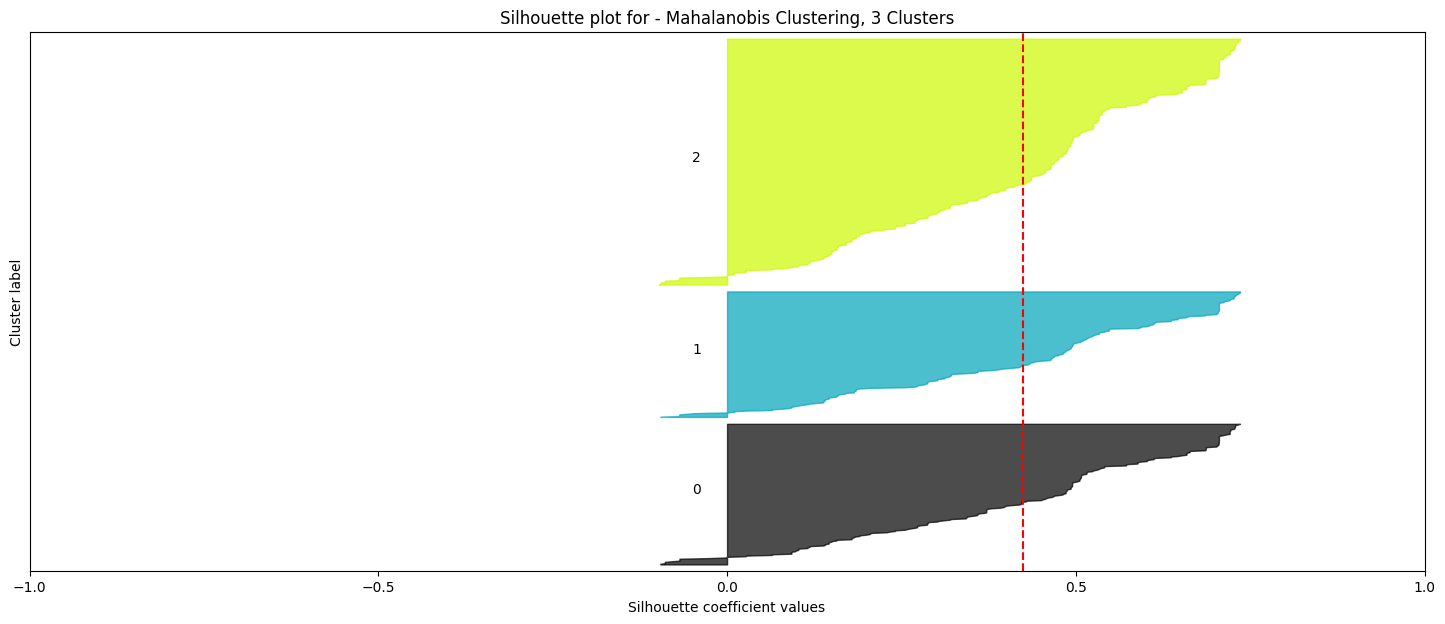

In [120]:
evaluation_mahalanobis3 = ClusterInternalEvaluation(cluster_mahalanobis3)
print("Davies-Bouldin Index:", evaluation_mahalanobis3.dbi)
print("Overall Silhouette Score:", evaluation_mahalanobis3.overall_silhouette_score)
evaluation_mahalanobis3._plot_silhouette()

In [114]:
cluster_mahalanobis2 = KmeansClusterMahalanobis(subjectsList, k=2, max_iterations=100)

Davies-Bouldin Index: 1.1785281760587674
Overall Silhouette Score: 0.36979038104039796


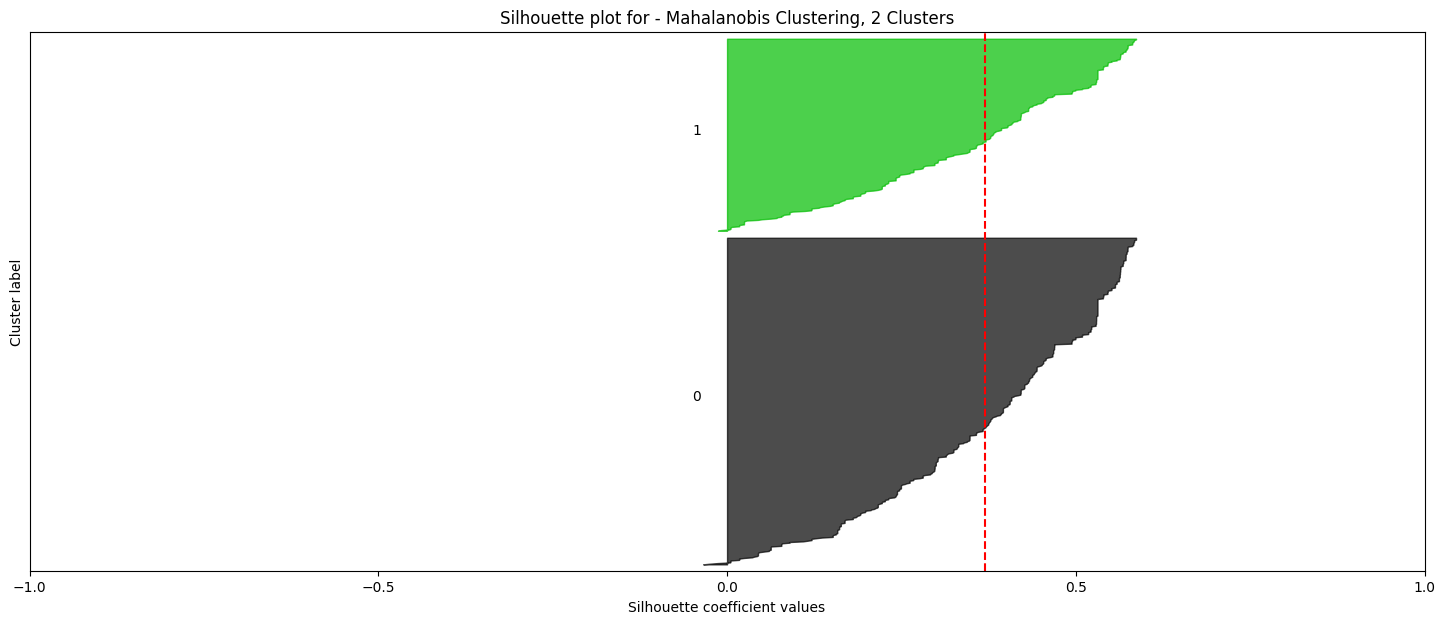

In [115]:
evaluation_mahalanobis2 = ClusterInternalEvaluation(cluster_mahalanobis2)
print("Davies-Bouldin Index:", evaluation_mahalanobis2.dbi)
print("Overall Silhouette Score:", evaluation_mahalanobis2.overall_silhouette_score)
evaluation_mahalanobis2._plot_silhouette()

### Elbow method and knee point

In [98]:
max_k = 10  # maximum number of clusters to consider
max_iter=100 # maximum iterations

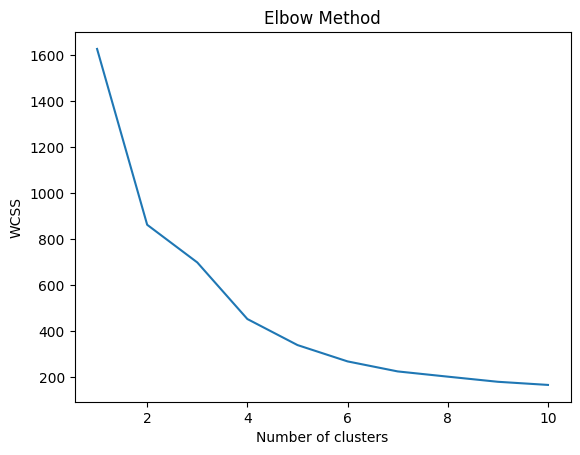

In [99]:
wcss_euclidean=compute_elbow(subjectsList, max_k, max_iter, use_mahalanobis=False)

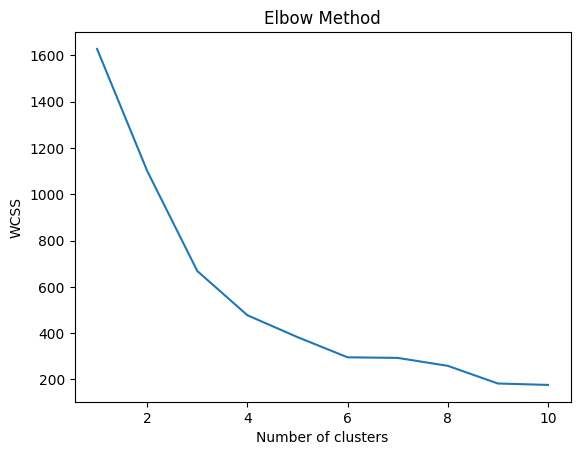

In [100]:
wcss_mahalanobis = compute_elbow(subjectsList, max_k, max_iter, use_mahalanobis=True)

In [101]:
knee_point = compute_kneedle(wcss_euclidean)

knee point is at cluster number: 1


In [102]:
knee_point = compute_kneedle(wcss_mahalanobis)

knee point is at cluster number: 1


### Cross-validation

In [103]:
k = 10 # number of clusters;
number_folds=10
results = holdout_cross_validation(subjectsList, k, number_folds);

In [104]:
for name, values in results.items():
    clustering_type, metric_type = name.split('_')
    mean_score = values['mean']
    conf_int_low, conf_int_high = values['conf_int']

    print(f"{clustering_type.capitalize()} Clustering - {metric_type.capitalize()}:")
    print(f"  Mean: {mean_score:.3f}")
    print(f"  Confidence Interval: [{conf_int_low:.3f}, {conf_int_high:.3f}]\n")

Euclidean Clustering - Silhouette:
  Mean: 0.420
  Confidence Interval: [0.409, 0.431]

Euclidean Clustering - Dbi:
  Mean: 0.814
  Confidence Interval: [0.796, 0.832]

Mahalanobis Clustering - Silhouette:
  Mean: 0.433
  Confidence Interval: [0.426, 0.440]

Mahalanobis Clustering - Dbi:
  Mean: 0.782
  Confidence Interval: [0.746, 0.817]



In [105]:
k_range = range(2, 10)
number_folds = 10

In [106]:
for k in k_range:
    print(f"Clustering with k = {k}")
    results = holdout_cross_validation(subjectsList, k, number_folds)

    for name, values in results.items():
        clustering_type, metric_type = name.split('_')
        mean_score = values['mean']
        conf_int_low, conf_int_high = values['conf_int']

        print(f"{clustering_type.capitalize()} Clustering - {metric_type.capitalize()}:")
        print(f"  Mean: {mean_score:.3f}")
        print(f"  Confidence Interval: [{conf_int_low:.3f}, {conf_int_high:.3f}]\n")
    
    print("--------")


Clustering with k = 2
Euclidean Clustering - Silhouette:
  Mean: 0.464
  Confidence Interval: [0.455, 0.473]

Euclidean Clustering - Dbi:
  Mean: 0.907
  Confidence Interval: [0.888, 0.925]

Mahalanobis Clustering - Silhouette:
  Mean: 0.392
  Confidence Interval: [0.381, 0.403]

Mahalanobis Clustering - Dbi:
  Mean: 1.138
  Confidence Interval: [1.115, 1.161]

--------
Clustering with k = 3
Euclidean Clustering - Silhouette:
  Mean: 0.403
  Confidence Interval: [0.387, 0.419]

Euclidean Clustering - Dbi:
  Mean: 0.912
  Confidence Interval: [0.856, 0.969]

Mahalanobis Clustering - Silhouette:
  Mean: 0.429
  Confidence Interval: [0.423, 0.435]

Mahalanobis Clustering - Dbi:
  Mean: 0.847
  Confidence Interval: [0.837, 0.856]

--------
Clustering with k = 4
Euclidean Clustering - Silhouette:
  Mean: 0.415
  Confidence Interval: [0.397, 0.432]

Euclidean Clustering - Dbi:
  Mean: 0.871
  Confidence Interval: [0.842, 0.901]

Mahalanobis Clustering - Silhouette:
  Mean: 0.428
  Confidence

### External evaluation
Ground trouth check; 

In [107]:
cluster_euclidean3 = KmeansClusterEuclidean(subjectsList, k=3, max_iterations=100)

In [108]:
three_cluster_eval = ThreeClusterExternalEvaluation(cluster_euclidean3, 1)
three_cluster_eval.evaluate_cluster_labels()
three_cluster_eval.compute_average_metrics()
three_cluster_eval.print_metrics()
#three_cluster_eval.plot_all_metrics()

Metrics for Smallest Label:
  accuracy: 0.4258
  precision: 0.0457
  recall: 0.2111
  f1_score: 0.0751
  auc: 0.0026
  auprc: 0.0034


Metrics for Largest Label:
  accuracy: 0.3387
  precision: 0.6375
  recall: 0.2529
  f1_score: 0.3621
  auc: 0.0000
  auprc: 0.0000


Metrics for Other Label:
  accuracy: 0.8712
  precision: 0.5472
  recall: 0.7250
  f1_score: 0.6237
  auc: 0.0000
  auprc: 0.0000


Average Metrics Across Label Sets:
  accuracy: 0.5452
  precision: 0.4101
  recall: 0.3963
  f1_score: 0.3536
  auc: 0.0009
  auprc: 0.0011


In [109]:
cluster_mahalanobis3 = KmeansClusterMahalanobis(subjectsList, k=3, max_iterations=100)

In [110]:
three_cluster_evalM = ThreeClusterExternalEvaluation(cluster_mahalanobis3, 1)
three_cluster_evalM.evaluate_cluster_labels()
three_cluster_evalM.compute_average_metrics()
three_cluster_evalM.print_metrics()
#three_cluster_eval.plot_all_metrics()

Metrics for Smallest Label:
  accuracy: 0.4086
  precision: 0.0421
  recall: 0.2000
  f1_score: 0.0695
  auc: 0.0006
  auprc: 0.0028


Metrics for Largest Label:
  accuracy: 0.2982
  precision: 0.5855
  recall: 0.1868
  f1_score: 0.2832
  auc: 0.0000
  auprc: 0.0040


Metrics for Other Label:
  accuracy: 0.8552
  precision: 0.5052
  recall: 0.8167
  f1_score: 0.6242
  auc: 0.0000
  auprc: 0.0000


Average Metrics Across Label Sets:
  accuracy: 0.5207
  precision: 0.3776
  recall: 0.4011
  f1_score: 0.3256
  auc: 0.0002
  auprc: 0.0023


#### External evaluation with corss-validation

This is done only with 3 cluster, because of the ground truth data.

In [111]:
results_euclidean, results_mahalanobis = three_external_holdout_cross_validation(subjectsList, 1, 10, 0.95)

print("Euclidean Clustering Results:")
for metric, values in results_euclidean.items():
    print(f"{metric}: Mean = {values['mean']:.4f}, SD = {values['sd']:.4f}, 95% CI = {values['95% CI']}")

print("\nMahalanobis Clustering Results:")
for metric, values in results_mahalanobis.items():
    print(f"{metric}: Mean = {values['mean']:.4f}, SD = {values['sd']:.4f}, 95% CI = {values['95% CI']}")

Euclidean Clustering Results:
accuracy: Mean = 0.5282, SD = 0.1582, 95% CI = (0.47760363975858355, 0.5787706292472644)
precision: Mean = 0.2756, SD = 0.2774, 95% CI = (0.186922317874954, 0.36434681384982565)
recall: Mean = 0.2282, SD = 0.2134, 95% CI = (0.15989383675449437, 0.29642145958558247)
f1_score: Mean = 0.2144, SD = 0.2141, 95% CI = (0.14598619285419454, 0.28290493639841974)
auc: Mean = 0.0553, SD = 0.1455, 95% CI = (0.008783096121120305, 0.10186089640922227)
auprc: Mean = 0.0453, SD = 0.1100, 95% CI = (0.010142075724842124, 0.08047132139370844)

Mahalanobis Clustering Results:
accuracy: Mean = 0.5138, SD = 0.1898, 95% CI = (0.453114378365602, 0.5744879608156848)
precision: Mean = 0.3532, SD = 0.2099, 95% CI = (0.2860906358260258, 0.4203797056069378)
recall: Mean = 0.3738, SD = 0.2487, 95% CI = (0.29426877488736325, 0.4533321774036597)
f1_score: Mean = 0.2975, SD = 0.1853, 95% CI = (0.2382779422259284, 0.3568066500117006)
auc: Mean = 0.0549, SD = 0.0663, 95% CI = (0.03372485745

## Final plots

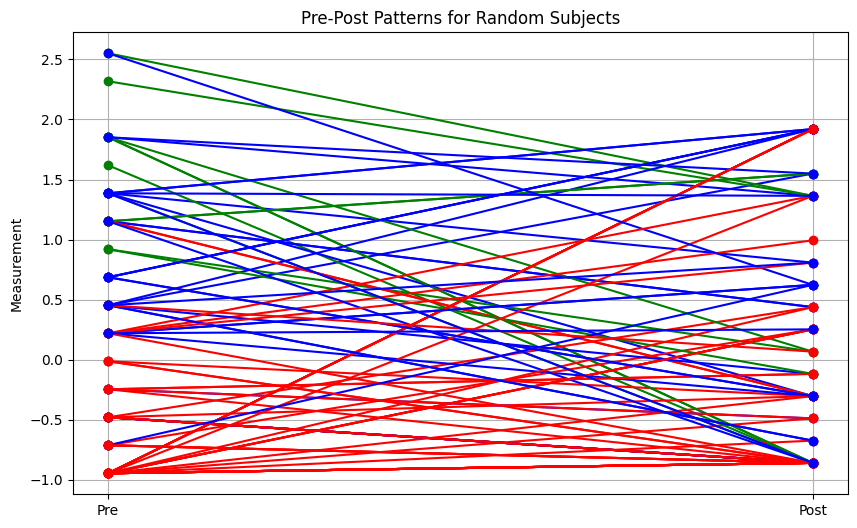

In [112]:
cluster_euclidean = KmeansClusterEuclidean(subjectsList, k=3, max_iterations=100)
random_subjects = np.random.choice(cluster_euclidean.subjects, 100, replace=False)
plt.figure(figsize=(10, 6))  #figure size

cluster_colors = ['red', 'blue', 'green']

for subject in random_subjects:
    pre_post_data = subject.pre_post_features
    cluster_label = subject.cluster_label

    x = ['Pre', 'Post']
    y = pre_post_data
    color = cluster_colors[cluster_label - 1] 
    plt.plot(x, y, color=color, marker='o')

plt.ylabel('Measurement')
plt.title('Pre-Post Patterns for Random Subjects')
plt.grid()
plt.show()

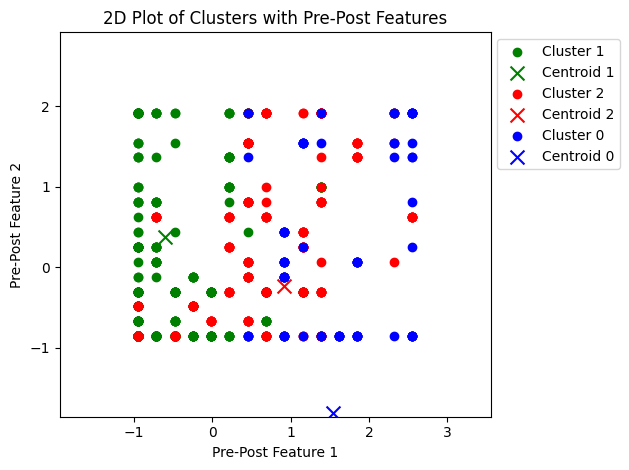

In [113]:
subjects = cluster_euclidean.subjects
centroids = cluster_euclidean.centroids
plot_clusters(subjects, centroids)